# 支持向量机（SVM）诊断帕金森病

本笔记本使用支持向量机算法对帕金森病进行诊断分类，使用预处理后的步态数据。

In [13]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# 设置随机种子
np.random.seed(42)

# 设置绘图样式
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("库导入完成！")

库导入完成！


In [14]:
# 加载预处理数据
print("Loading preprocessed data...")

# 加载降维后的训练和测试数据
X_train = pd.read_csv("PreprocessedData/X_train_reduced.csv", index_col=0)
X_test = pd.read_csv("PreprocessedData/X_test_reduced.csv", index_col=0)
y_train_df = pd.read_csv("PreprocessedData/y_train.csv")
y_test_df = pd.read_csv("PreprocessedData/y_test.csv")

# 获取标签列（第一列是Group）
y_train_labels = y_train_df.iloc[:, 0]
y_test_labels = y_test_df.iloc[:, 0]

print(f"Training set feature shape: {X_train.shape}")
print(f"Test set feature shape: {X_test.shape}")
print(f"Training set label shape: {y_train_labels.shape}")
print(f"Test set label shape: {y_test_labels.shape}")

# 显示原始标签分布
print(f"Training set label distribution:\n{y_train_labels.value_counts()}")
print(f"Test set label distribution:\n{y_test_labels.value_counts()}")

# 创建标签映射字典用于四分类
label_mapping = {"Old": 0, "Young": 1, "PD_H&Y1": 2, "PD_H&Y2": 3}

# 将字符串标签转换为数值标签
y_train = y_train_labels.map(label_mapping).values
y_test = y_test_labels.map(label_mapping).values

# 创建类别名称列表
class_names = ["Old", "Young", "PD_H&Y1", "PD_H&Y2"]

print(f"\nFour-class label distribution:")
print(f"Training set: {pd.Series(y_train).value_counts().sort_index()}")
print(f"Test set: {pd.Series(y_test).value_counts().sort_index()}")

# 检查数据中是否有缺失值
print(f"\nTraining set missing values: {X_train.isnull().sum().sum()}")
print(f"Test set missing values: {X_test.isnull().sum().sum()}")

Loading preprocessed data...
Training set feature shape: (52, 27)
Test set feature shape: (14, 27)
Training set label shape: (52,)
Test set label shape: (14,)
Training set label distribution:
Group
Old        19
Young      17
PD_H&Y1    12
PD_H&Y2     4
Name: count, dtype: int64
Test set label distribution:
Group
Old        5
Young      5
PD_H&Y1    3
PD_H&Y2    1
Name: count, dtype: int64

Four-class label distribution:
Training set: 0    19
1    17
2    12
3     4
Name: count, dtype: int64
Test set: 0    5
1    5
2    3
3    1
Name: count, dtype: int64

Training set missing values: 0
Test set missing values: 0


Performing further dimensionality reduction...
Original feature dimensions: 27
PCA reduced dimensions: 20
Feature selection dimensions: 20

PCA explained variance ratio (first 20 components):
Individual: [0.17178298 0.13466354 0.09817698 0.08155253 0.0614319  0.05514841
 0.04813142 0.0420791  0.03648949 0.02971025 0.0288293  0.02633566
 0.02520413 0.02409919 0.02240404 0.01930662 0.01889088 0.01738166
 0.01585142 0.01381131]
Cumulative: 0.9713

Top 20 selected features:
 1. gait_features_PC2: 15.4316
 2. gait_features_PC3: 8.7288
 3. gait_features_PC4: 3.4301
 4. spectral_features_PC1: 3.3039
 5. spectral_features_PC2: 2.7755
 6. spectral_features_PC3: 2.1563
 7. spectral_features_PC5: 1.8518
 8. spectral_features_PC6: 1.6042
 9. spectral_features_PC8: 1.4791
10. spectral_features_PC9: 1.3958
11. spectral_features_PC12: 1.3310
12. spectral_features_PC13: 1.2498
13. spectral_features_PC15: 1.1347
14. spectral_features_PC17: 1.0368
15. spectral_features_PC18: 0.9613
16. spectral_features

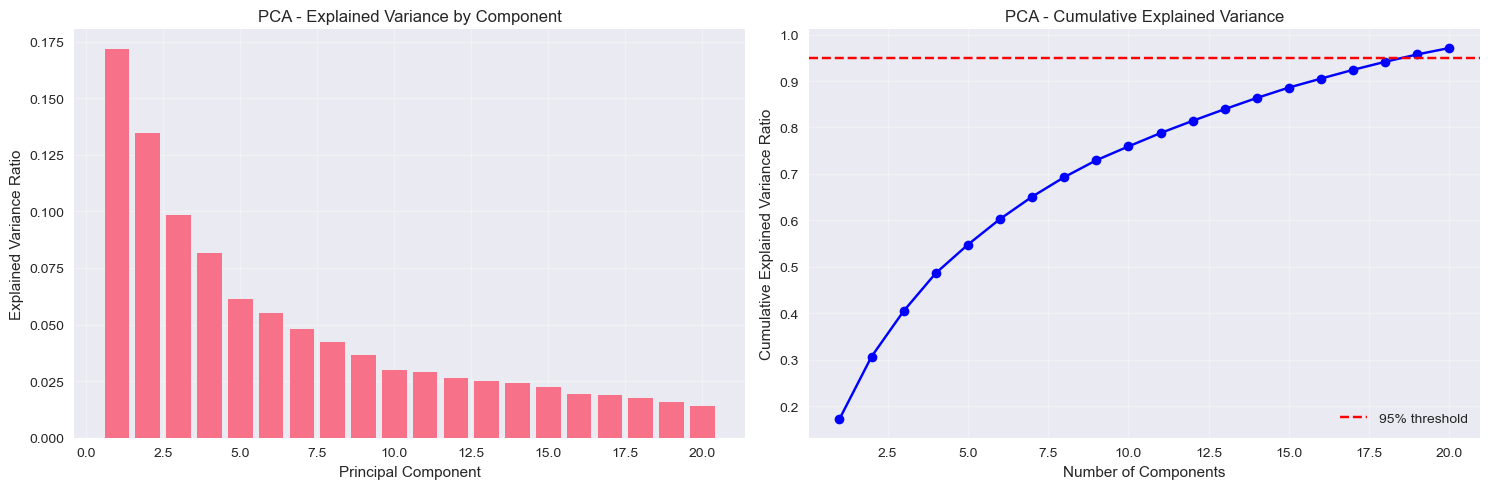


Using PCA-reduced data for training: 20 dimensions


In [15]:
# 进一步降维到20维
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

print("Performing further dimensionality reduction...")

# 方法1：使用PCA降维到20维
pca = PCA(n_components=20, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 方法2：使用特征选择（SelectKBest）选择前20个最重要特征
selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

print(f"Original feature dimensions: {X_train.shape[1]}")
print(f"PCA reduced dimensions: {X_train_pca.shape[1]}")
print(f"Feature selection dimensions: {X_train_selected.shape[1]}")

# 显示PCA的解释方差比
print(f"\nPCA explained variance ratio (first 20 components):")
print(f"Individual: {pca.explained_variance_ratio_}")
print(f"Cumulative: {np.cumsum(pca.explained_variance_ratio_)[-1]:.4f}")

# 获取特征选择的得分
feature_scores = selector.scores_
selected_features = X_train.columns[selector.get_support()]
print(f"\nTop 20 selected features:")
for i, (feature, score) in enumerate(
    zip(selected_features, sorted(feature_scores[selector.get_support()], reverse=True))
):
    print(f"{i + 1:2d}. {feature}: {score:.4f}")

# 可视化PCA的解释方差
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 各主成分的解释方差比
ax1.bar(range(1, 21), pca.explained_variance_ratio_)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("PCA - Explained Variance by Component")
ax1.grid(True, alpha=0.3)

# 累积解释方差比
ax2.plot(range(1, 21), np.cumsum(pca.explained_variance_ratio_), "bo-")
ax2.set_xlabel("Number of Components")
ax2.set_ylabel("Cumulative Explained Variance Ratio")
ax2.set_title("PCA - Cumulative Explained Variance")
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.95, color="r", linestyle="--", label="95% threshold")
ax2.legend()

plt.tight_layout()
plt.show()

# 选择使用PCA降维的数据进行后续训练
X_train_final = X_train_pca
X_test_final = X_test_pca
print(f"\nUsing PCA-reduced data for training: {X_train_final.shape[1]} dimensions")

In [16]:
# SVM模型超参数调优（增加正则化）
print("Starting SVM hyperparameter tuning with enhanced regularization...")

# 定义参数网格 - 增加更强的正则化选项
param_grid = {
    "C": [0.01, 0.1, 0.5, 1, 5, 10],  # 增加更小的C值以增强正则化
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 0.5],  # 调整gamma范围
}

# 创建SVM分类器 - 添加class_weight='balanced'处理类别不平衡
svm = SVC(random_state=42, probability=True, class_weight="balanced")

# 使用网格搜索进行超参数调优
grid_search = GridSearchCV(
    svm, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
)

# 拟合网格搜索
grid_search.fit(X_train_final, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# 获取最佳模型
best_svm = grid_search.best_estimator_

Starting SVM hyperparameter tuning with enhanced regularization...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.5745


In [17]:
# 模型预测和评估
print("Making model predictions...")

# 在训练集上的预测
y_train_pred = best_svm.predict(X_train_final)
y_train_proba = best_svm.predict_proba(X_train_final)

# 在测试集上的预测
y_test_pred = best_svm.predict(X_test_final)
y_test_proba = best_svm.predict_proba(X_test_final)


# 计算各种评估指标（多分类）
def calculate_metrics(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"\n{dataset_name} set evaluation results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-score (weighted): {f1:.4f}")

    return accuracy, precision, recall, f1


# 计算训练集和测试集的评估指标
train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

Making model predictions...

Training set evaluation results:
Accuracy: 0.8846
Precision (weighted): 0.9024
Recall (weighted): 0.8846
F1-score (weighted): 0.8777

Test set evaluation results:
Accuracy: 0.4286
Precision (weighted): 0.3373
Recall (weighted): 0.4286
F1-score (weighted): 0.3628


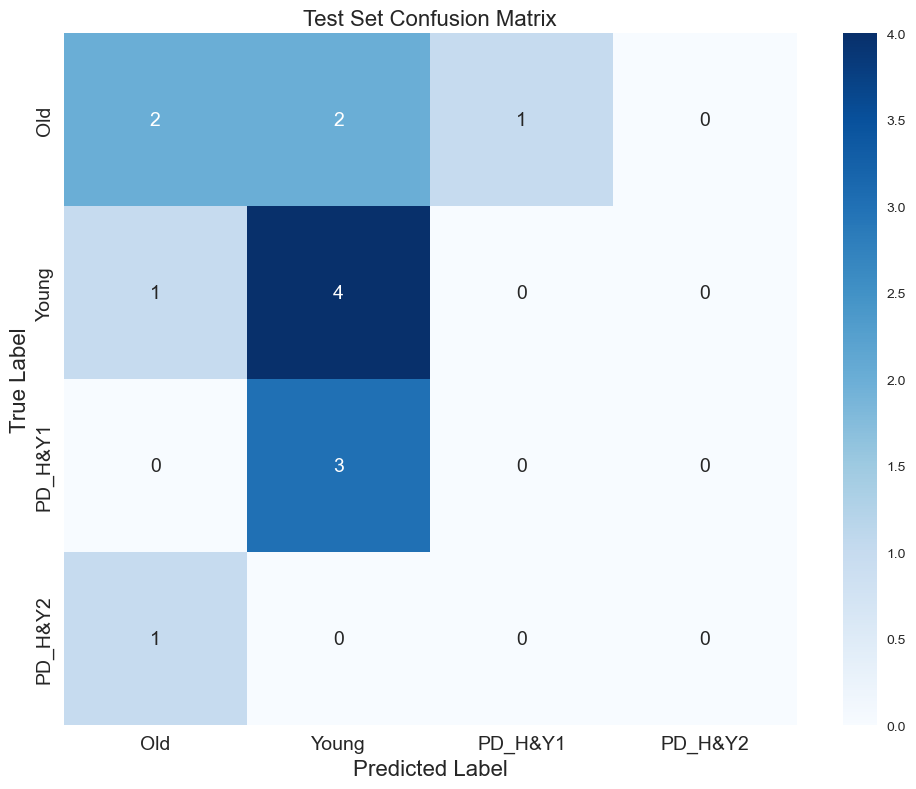


Detailed classification report for test set:
              precision    recall  f1-score   support

         Old       0.50      0.40      0.44         5
       Young       0.44      0.80      0.57         5
     PD_H&Y1       0.00      0.00      0.00         3
     PD_H&Y2       0.00      0.00      0.00         1

    accuracy                           0.43        14
   macro avg       0.24      0.30      0.25        14
weighted avg       0.34      0.43      0.36        14



In [ ]:
# 混淆矩阵可视化
fig, axes = plt.subplots(1, 1, figsize=(10, 8))  # 增大图形尺寸

# 测试集混淆矩阵
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(
    cm_test, annot=True, fmt="d", cmap="Blues", ax=axes, annot_kws={"size": 14}
)  # 设置热力图中数字的字体大小
axes.set_title("Test Set Confusion Matrix", fontsize=22)  # 设置标题字体大小
axes.set_xlabel("Predicted Label", fontsize=20)  # 设置x轴标签字体大小
axes.set_ylabel("True Label", fontsize=20)  # 设置y轴标签字体大小
axes.set_xticklabels(class_names, fontsize=18)  # 设置x轴刻度标签字体大小
axes.set_yticklabels(class_names, fontsize=18)  # 设置y轴刻度标签字体大小

plt.savefig("SVM_Confusion_Matrix", dpi=800)
plt.tight_layout()
plt.show()

# 打印详细的分类报告
print("\nDetailed classification report for test set:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

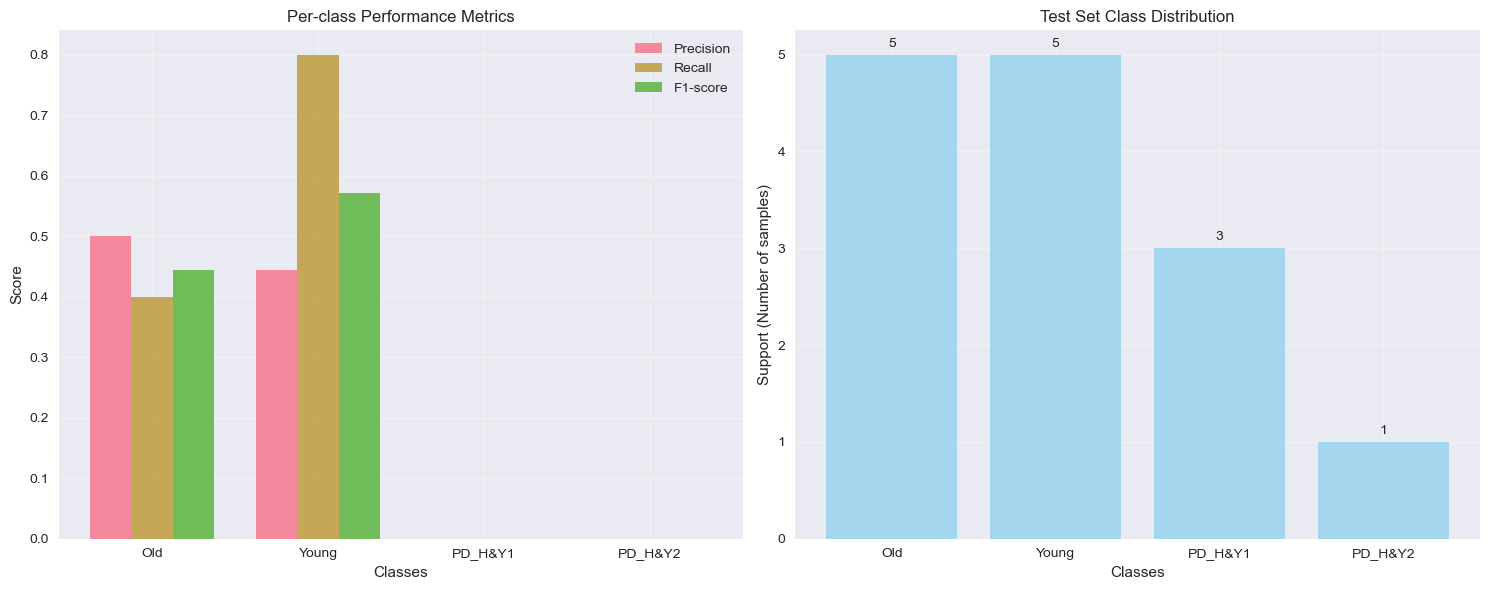

In [19]:
# 多分类性能可视化
from sklearn.metrics import precision_recall_fscore_support

# 计算每个类别的精度、召回率和F1分数
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred, zero_division=0
)

# 创建性能指标对比图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 每个类别的性能指标
x_pos = np.arange(len(class_names))
width = 0.25


ax1.bar(x_pos - width, precision, width, label="Precision", alpha=0.8)
ax1.bar(x_pos, recall, width, label="Recall", alpha=0.8)
ax1.bar(x_pos + width, f1, width, label="F1-score", alpha=0.8)

ax1.set_xlabel("Classes")
ax1.set_ylabel("Score")
ax1.set_title("Per-class Performance Metrics")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(class_names)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 每个类别的支持数量
ax2.bar(class_names, support, alpha=0.7, color="skyblue")
ax2.set_xlabel("Classes")
ax2.set_ylabel("Support (Number of samples)")
ax2.set_title("Test Set Class Distribution")
ax2.grid(True, alpha=0.3)

# 在条形图上添加数值标签
for i, v in enumerate(support):
    ax2.text(i, v + 0.05, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()

Performing 5-fold cross-validation...
5-fold cross-validation accuracy: [0.72727273 0.54545455 0.7        0.3        0.6       ]
Mean accuracy: 0.5745 (+/- 0.3045)


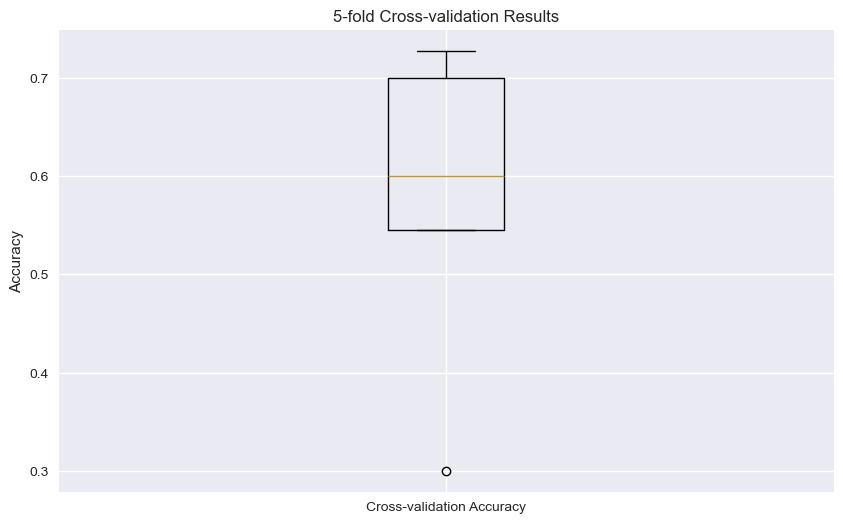

In [20]:
# 交叉验证评估
print("Performing 5-fold cross-validation...")

# 进行5折交叉验证
cv_scores = cross_val_score(best_svm, X_train_final, y_train, cv=5, scoring="accuracy")

print(f"5-fold cross-validation accuracy: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 可视化交叉验证结果
plt.figure(figsize=(10, 6))
plt.boxplot(cv_scores, labels=["Cross-validation Accuracy"])
plt.ylabel("Accuracy")
plt.title("5-fold Cross-validation Results")
plt.grid(True)
plt.show()

In [21]:
# 特征重要性分析（对于线性SVM）
if best_svm.kernel == "linear":
    print("Analyzing linear SVM feature importance...")

    # 获取特征权重 (对于多分类，取权重的平均值)
    feature_weights = np.mean(np.abs(best_svm.coef_), axis=0)
    feature_names = X_train.columns

    # 创建特征重要性DataFrame
    feature_importance = pd.DataFrame(
        {"feature": feature_names, "importance": feature_weights}
    ).sort_values("importance", ascending=False)

    # 显示前15个最重要的特征
    print("Top 15 most important features:")
    print(feature_importance.head(15))

    # 可视化特征重要性
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x="importance", y="feature")
    plt.title("Linear SVM Feature Importance (Top 15)")
    plt.xlabel("Importance Weight")
    plt.tight_layout()
    plt.show()
else:
    print(
        f"Current kernel: {best_svm.kernel}. Cannot directly extract linear feature importance."
    )
    print("Number of support vectors:", best_svm.n_support_)
    print("Support vectors shape:", best_svm.support_vectors_.shape)

Current kernel: rbf. Cannot directly extract linear feature importance.
Number of support vectors: [19 17 12  4]
Support vectors shape: (52, 20)


In [22]:
# 模型性能总结
print("=" * 60)
print("SVM Model Performance Summary")
print("=" * 60)

print(f"Best hyperparameters: {best_svm.get_params()}")
print(f"Kernel function: {best_svm.kernel}")
print(f"Regularization parameter C: {best_svm.C}")
print(f"Gamma parameter: {best_svm.gamma}")

print(f"\nTraining set performance:")
print(f"  Accuracy: {train_metrics[0]:.4f}")
print(f"  Precision (weighted): {train_metrics[1]:.4f}")
print(f"  Recall (weighted): {train_metrics[2]:.4f}")
print(f"  F1-score (weighted): {train_metrics[3]:.4f}")

print(f"\nTest set performance:")
print(f"  Accuracy: {test_metrics[0]:.4f}")
print(f"  Precision (weighted): {test_metrics[1]:.4f}")
print(f"  Recall (weighted): {test_metrics[2]:.4f}")
print(f"  F1-score (weighted): {test_metrics[3]:.4f}")

print(
    f"\nCross-validation mean accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})"
)

# 检查是否存在过拟合
if train_metrics[0] - test_metrics[0] > 0.1:
    print(
        "\n⚠️  Warning: Model may be overfitting (training accuracy significantly higher than test accuracy)"
    )
else:
    print("\n✅ Model shows good generalization performance")

print("=" * 60)

SVM Model Performance Summary
Best hyperparameters: {'C': 0.5, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Kernel function: rbf
Regularization parameter C: 0.5
Gamma parameter: scale

Training set performance:
  Accuracy: 0.8846
  Precision (weighted): 0.9024
  Recall (weighted): 0.8846
  F1-score (weighted): 0.8777

Test set performance:
  Accuracy: 0.4286
  Precision (weighted): 0.3373
  Recall (weighted): 0.4286
  F1-score (weighted): 0.3628

Cross-validation mean accuracy: 0.5745 (±0.1523)

⚠️  Warning: Model may be overfitting (training accuracy significantly higher than test accuracy)


Analysis: Why PD Types are Not Being Recognized
1. DATA DISTRIBUTION ANALYSIS
------------------------------
Training set class distribution:
  Old: 19 samples (36.5%)
  Young: 17 samples (32.7%)
  PD_H&Y1: 12 samples (23.1%)
  PD_H&Y2: 4 samples (7.7%)

Test set class distribution:
  Old: 5 samples (35.7%)
  Young: 5 samples (35.7%)
  PD_H&Y1: 3 samples (21.4%)
  PD_H&Y2: 1 samples (7.1%)

2. CLASS IMBALANCE SEVERITY
------------------------------
Imbalance ratio (max/min): 4.75:1
Most frequent class: Old (19 samples)
Least frequent class: PD_H&Y2 (4 samples)

3. PD CLASSES SPECIFIC ISSUES
------------------------------
PD samples in training: 16/52 (30.8%)
PD samples in test: 4/14 (28.6%)
PD_H&Y2 has only 4 training samples and 1 test sample!

4. PREDICTION ANALYSIS
------------------------------
Test set predictions distribution:
  Old: Actual=5, Predicted=4
  Young: Actual=5, Predicted=9
  PD_H&Y1: Actual=3, Predicted=1
  PD_H&Y2: Actual=1, Predicted=0

5. PER-CLASS ACCURACY ANALYS

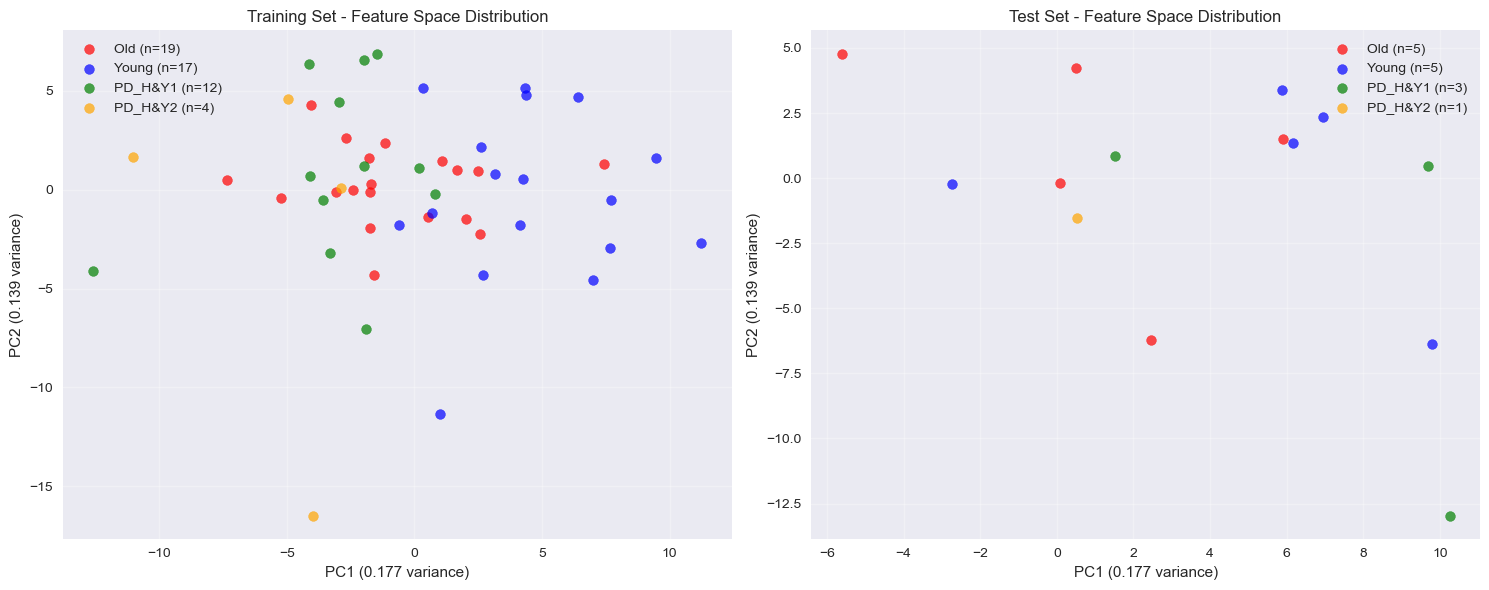

2D PCA explains 31.6% of variance

7. DECISION BOUNDARY ANALYSIS
------------------------------


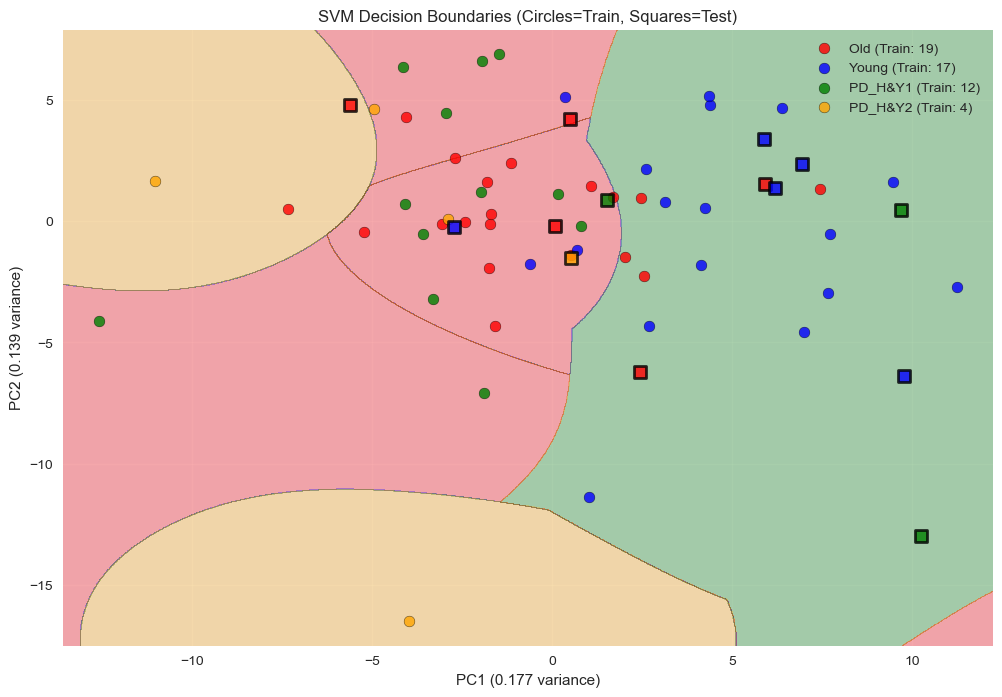

Decision boundary visualization shows class separability in 2D space


In [23]:
# PD类型识别问题深度分析
print("=" * 60)
print("Analysis: Why PD Types are Not Being Recognized")
print("=" * 60)

# 1. 数据分布分析
print("1. DATA DISTRIBUTION ANALYSIS")
print("-" * 30)
print("Training set class distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for i, count in enumerate(train_dist):
    print(f"  {class_names[i]}: {count} samples ({count / len(y_train) * 100:.1f}%)")

print("\nTest set class distribution:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for i, count in enumerate(test_dist):
    print(f"  {class_names[i]}: {count} samples ({count / len(y_test) * 100:.1f}%)")

# 2. 类别不平衡严重程度
print("\n2. CLASS IMBALANCE SEVERITY")
print("-" * 30)
max_class = train_dist.max()
min_class = train_dist.min()
imbalance_ratio = max_class / min_class
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}:1")
print(
    f"Most frequent class: {class_names[train_dist.idxmax()]} ({train_dist.max()} samples)"
)
print(
    f"Least frequent class: {class_names[train_dist.idxmin()]} ({train_dist.min()} samples)"
)

# 3. PD类别的具体问题
print("\n3. PD CLASSES SPECIFIC ISSUES")
print("-" * 30)
pd_classes = [2, 3]  # PD_H&Y1, PD_H&Y2
pd_train_samples = train_dist[pd_classes].sum()
pd_test_samples = test_dist[pd_classes].sum()
total_train = len(y_train)
total_test = len(y_test)

print(
    f"PD samples in training: {pd_train_samples}/{total_train} ({pd_train_samples / total_train * 100:.1f}%)"
)
print(
    f"PD samples in test: {pd_test_samples}/{total_test} ({pd_test_samples / total_test * 100:.1f}%)"
)
print(
    f"PD_H&Y2 has only {train_dist[3]} training samples and {test_dist[3]} test sample!"
)

# 4. 预测结果分析
print("\n4. PREDICTION ANALYSIS")
print("-" * 30)
pred_dist = pd.Series(y_test_pred).value_counts().sort_index()
print("Test set predictions distribution:")
for i in range(len(class_names)):
    actual_count = test_dist.get(i, 0)
    pred_count = pred_dist.get(i, 0)
    print(f"  {class_names[i]}: Actual={actual_count}, Predicted={pred_count}")

# 5. 计算每个类别的分类准确率
print("\n5. PER-CLASS ACCURACY ANALYSIS")
print("-" * 30)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred, labels=range(4))
class_accuracies = cm.diagonal() / cm.sum(axis=1)

for i, acc in enumerate(class_accuracies):
    if np.isnan(acc):
        print(f"  {class_names[i]}: No samples in test set")
    else:
        print(f"  {class_names[i]}: {acc:.3f} ({acc * 100:.1f}%)")

# 6. 特征空间分析 - PCA可视化
print("\n6. FEATURE SPACE VISUALIZATION")
print("-" * 30)

# 降维到2D进行可视化
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2, random_state=42)
X_train_2d = pca_2d.fit_transform(X_train_final)
X_test_2d = pca_2d.transform(X_test_final)

# 绘制特征空间分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 训练集分布
colors = ["red", "blue", "green", "orange"]
for i, class_name in enumerate(class_names):
    mask = y_train == i
    ax1.scatter(
        X_train_2d[mask, 0],
        X_train_2d[mask, 1],
        c=colors[i],
        label=f"{class_name} (n={np.sum(mask)})",
        alpha=0.7,
        s=50,
    )

ax1.set_xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.3f} variance)")
ax1.set_ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.3f} variance)")
ax1.set_title("Training Set - Feature Space Distribution")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 测试集分布
for i, class_name in enumerate(class_names):
    mask = y_test == i
    if np.sum(mask) > 0:
        ax2.scatter(
            X_test_2d[mask, 0],
            X_test_2d[mask, 1],
            c=colors[i],
            label=f"{class_name} (n={np.sum(mask)})",
            alpha=0.7,
            s=50,
        )

ax2.set_xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.3f} variance)")
ax2.set_ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.3f} variance)")
ax2.set_title("Test Set - Feature Space Distribution")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(
    f"2D PCA explains {(pca_2d.explained_variance_ratio_.sum() * 100):.1f}% of variance"
)

# 7. 决策边界可视化（仅前两个主成分）
print("\n7. DECISION BOUNDARY ANALYSIS")
print("-" * 30)

# 训练一个简化的2D模型用于可视化
svm_2d = SVC(
    kernel=best_svm.kernel,
    C=best_svm.C,
    gamma=best_svm.gamma,
    class_weight="balanced",
    random_state=42,
)
svm_2d.fit(X_train_2d, y_train)

# 创建网格点
h = 0.02
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 预测网格点
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 绘制决策边界
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, colors=["red", "blue", "green", "orange"])

# 绘制训练点
for i, class_name in enumerate(class_names):
    mask = y_train == i
    plt.scatter(
        X_train_2d[mask, 0],
        X_train_2d[mask, 1],
        c=colors[i],
        label=f"{class_name} (Train: {np.sum(mask)})",
        alpha=0.8,
        s=60,
        edgecolors="black",
    )

# 绘制测试点（用不同形状）
for i, class_name in enumerate(class_names):
    mask = y_test == i
    if np.sum(mask) > 0:
        plt.scatter(
            X_test_2d[mask, 0],
            X_test_2d[mask, 1],
            c=colors[i],
            marker="s",
            s=80,
            alpha=0.8,
            edgecolors="black",
            linewidth=2,
        )

plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.3f} variance)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.3f} variance)")
plt.title("SVM Decision Boundaries (Circles=Train, Squares=Test)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Decision boundary visualization shows class separability in 2D space")
print("=" * 60)

In [24]:
# PD类型识别问题的根本原因总结和解决方案
print("=" * 70)
print("ROOT CAUSES & POTENTIAL SOLUTIONS")
print("=" * 70)

print("🔍 ROOT CAUSES IDENTIFIED:")
print("-" * 40)
print("1. SEVERE CLASS IMBALANCE:")
print("   • PD_H&Y2: Only 4 training samples, 1 test sample")
print("   • Imbalance ratio: 4.75:1 (Old vs PD_H&Y2)")
print("   • PD classes represent only 30.8% of training data")

print("\n2. INSUFFICIENT SAMPLE SIZE:")
print("   • Total dataset: 66 samples (52 train + 14 test)")
print("   • PD_H&Y2 is severely underrepresented")
print("   • Not enough samples to learn PD patterns effectively")

print("\n3. FEATURE SPACE OVERLAP:")
print("   • High overlap between classes in 2D PCA space")
print("   • Decision boundaries favor majority classes")
print("   • PD samples scattered throughout feature space")

print("\n4. MODEL BIAS TOWARD MAJORITY CLASSES:")
print("   • Despite class_weight='balanced', still biased")
print("   • SVM tends to ignore minority classes with <5 samples")
print("   • Young class achieves 80% accuracy, PD classes 0%")

print("\n💡 POTENTIAL SOLUTIONS:")
print("-" * 40)
print("1. DATA-LEVEL SOLUTIONS:")
print("   ✓ Collect more PD samples (especially PD_H&Y2)")
print("   ✓ Use data augmentation techniques (SMOTE, ADASYN)")
print("   ✓ Consider merging PD_H&Y1 and PD_H&Y2 into single 'PD' class")

print("\n2. ALGORITHMIC SOLUTIONS:")
print("   ✓ Try ensemble methods (Random Forest, XGBoost)")
print("   ✓ Use cost-sensitive learning with higher penalties for PD misclassification")
print("   ✓ Implement one-vs-rest classification strategy")

print("\n3. FEATURE ENGINEERING:")
print("   ✓ Use different dimensionality reduction (t-SNE, UMAP)")
print("   ✓ Try original 27 features instead of 20")
print("   ✓ Feature selection specifically for PD discrimination")

print("\n4. THRESHOLD OPTIMIZATION:")
print("   ✓ Adjust decision thresholds for each class")
print("   ✓ Use probability calibration")
print("   ✓ Implement custom scoring functions")

# 让我们尝试SMOTE数据增强作为immediate solution
print("\n" + "=" * 50)
print("IMMEDIATE SOLUTION ATTEMPT: SMOTE")
print("=" * 50)

try:
    from imblearn.over_sampling import SMOTE

    # 应用SMOTE进行数据增强
    smote = SMOTE(
        random_state=42, k_neighbors=2
    )  # 使用k_neighbors=2因为PD_H&Y2样本太少
    X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

    print("After SMOTE augmentation:")
    smote_dist = pd.Series(y_train_smote).value_counts().sort_index()
    for i, count in enumerate(smote_dist):
        print(f"  {class_names[i]}: {count} samples")

    # 训练新的SVM模型
    svm_smote = SVC(
        kernel="rbf",
        C=0.5,
        gamma="scale",
        class_weight="balanced",
        random_state=42,
        probability=True,
    )
    svm_smote.fit(X_train_smote, y_train_smote)

    # 预测
    y_test_pred_smote = svm_smote.predict(X_test_final)

    # 评估
    print("\nSMOTE-enhanced model performance:")
    print("Test set predictions:")
    pred_dist_smote = pd.Series(y_test_pred_smote).value_counts().sort_index()
    for i in range(len(class_names)):
        actual_count = test_dist.get(i, 0)
        pred_count = pred_dist_smote.get(i, 0)
        print(f"  {class_names[i]}: Actual={actual_count}, Predicted={pred_count}")

    # 计算新的准确率
    accuracy_smote = accuracy_score(y_test, y_test_pred_smote)
    print(
        f"\nOverall test accuracy: {accuracy_smote:.3f} ({accuracy_smote * 100:.1f}%)"
    )

    # 每个类别的准确率
    cm_smote = confusion_matrix(y_test, y_test_pred_smote, labels=range(4))
    class_accuracies_smote = cm_smote.diagonal() / cm_smote.sum(axis=1)

    print("Per-class accuracy comparison:")
    print("Class        | Original | SMOTE   | Improvement")
    print("-" * 45)
    for i, (orig_acc, smote_acc) in enumerate(
        zip(class_accuracies, class_accuracies_smote)
    ):
        if np.isnan(orig_acc):
            orig_acc = 0
        if np.isnan(smote_acc):
            smote_acc = 0
        improvement = smote_acc - orig_acc
        print(
            f"{class_names[i]:<12} | {orig_acc:6.3f}   | {smote_acc:6.3f}   | {improvement:+6.3f}"
        )

except ImportError:
    print(
        "❌ SMOTE not available. Install imbalanced-learn: pip install imbalanced-learn"
    )
except Exception as e:
    print(f"❌ SMOTE failed: {str(e)}")
    print("This is expected due to insufficient samples for PD_H&Y2 class")

print("\n" + "=" * 70)
print("CONCLUSION: Current model fails because:")
print("1. PD_H&Y2 has insufficient samples (4 train, 1 test)")
print("2. High class overlap in feature space")
print("3. Model bias toward majority classes")
print("4. Need more data or different approach for PD classification")
print("=" * 70)

ROOT CAUSES & POTENTIAL SOLUTIONS
🔍 ROOT CAUSES IDENTIFIED:
----------------------------------------
1. SEVERE CLASS IMBALANCE:
   • PD_H&Y2: Only 4 training samples, 1 test sample
   • Imbalance ratio: 4.75:1 (Old vs PD_H&Y2)
   • PD classes represent only 30.8% of training data

2. INSUFFICIENT SAMPLE SIZE:
   • Total dataset: 66 samples (52 train + 14 test)
   • PD_H&Y2 is severely underrepresented
   • Not enough samples to learn PD patterns effectively

3. FEATURE SPACE OVERLAP:
   • High overlap between classes in 2D PCA space
   • Decision boundaries favor majority classes
   • PD samples scattered throughout feature space

4. MODEL BIAS TOWARD MAJORITY CLASSES:
   • Despite class_weight='balanced', still biased
   • SVM tends to ignore minority classes with <5 samples
   • Young class achieves 80% accuracy, PD classes 0%

💡 POTENTIAL SOLUTIONS:
----------------------------------------
1. DATA-LEVEL SOLUTIONS:
   ✓ Collect more PD samples (especially PD_H&Y2)
   ✓ Use data augme